<a href="https://colab.research.google.com/github/Ladvien/deep_arcane/blob/main/deep_arcane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Setup

In [1]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Install Weights and Biases for experiment tracking.  
!pip install wandb

     |████████████████████████████████| 1.8MB 5.1MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 163kB 16.6MB/s 
     |████████████████████████████████| 133kB 15.6MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=f1a8b3bab93c4925e1be6d495af00899fa2dfdcb12385b9452298c5f5d00e571
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [3]:
# Setup data directory.
!mkdir -p "/content/data/clean_bold_magic_symbols/"
!mkdir "/content/output/"

# You will need to upload your data file manually Google Drive.
!tar -xf  '/content/gdrive/MyDrive/datasets/clean_bold_magic_symbols.tar.gz' -C '/content/data/clean_bold_magic_symbols/'

In [4]:
from __future__ import print_function
#%matplotlib inlinea

import os

# Usual Suspects.
import numpy as np
import random

# PyTorch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Image Visualization.
from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid

# Experiment tracking.
import wandb

# Set random seed for reproducibility
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42



## Parameters

In [5]:
# Root directory for dataset
dataroot = f"{os.getcwd()}/data/"
output_folder = f"{os.getcwd()}/output/"

# Where to save models.
g_drive_models_dir = "dl_models/deep_arcane/"

# Model to load.
RESUME_ID = "3ewmebh2"
MODEL_DIR = "/content/gdrive/MyDrive/dl_models/deep_arcane_models/"

# Number of WORKERS for dataloader
WORKERS = 2

# Number of training epochs
EPOCHS = 6000
starting_epoch = 0

# Epoch to begin checking if we reached a new low loss.
EPOCH_TO_START_SAVING = 5

# Batch size during training
BATCH_SIZE = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 128

# Number of channels in the training images. For color images this is 3
NC = 1

# Size of z latent vector (i.e. size of generator input)
NZ = 25

# Size of feature maps in generator
NGF = 300

# Size of feature maps in discriminator
NDF = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

G_DROPOUT = 0.00
D_DROPOUT = 0.00

# Labels
real_range = (0.97, 0.95)
fake_range = (0.0, 0.0)

sample_every = 4
samples = 16

# How many epochs run before saving model
save_every = 20

# Image transformations.
convert_to_grayscale = True
resize_images = True
crop_images = True
random_rotation_degrees = (-0, 0)


# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

id = wandb.util.generate_id()

experiment_settings = {
    "wandb_run_id": id,
    "dataroot": dataroot,
    "WORKERS": WORKERS,
    "BATCH_SIZE": BATCH_SIZE,
    "IMAGE_SIZE":IMAGE_SIZE,
    "NC":NC,
    "NZ":NZ,
    "NGF":NGF,
    "NDF":NDF,
    "EPOCHS":EPOCHS,
    "lr":lr,
    "beta1":beta1,
    "G_DROPOUT":G_DROPOUT,
    "D_DROPOUT":D_DROPOUT,
    "real_range":real_range,
    "fake_range":fake_range,
    "ngpu":ngpu,
    "convert_to_grayscale": convert_to_grayscale,
    "resize_images": resize_images,
    "crop_images": crop_images,
    "random_rotation_degrees": random_rotation_degrees
}

In [6]:
# Initialze Weights and Biases.  You'll need account.
if RESUME_ID != "":
    wandb.init(id=RESUME_ID, config=experiment_settings, project="deep-arcane", resume="allow")
else:
    wandb.init(config=experiment_settings, project="deep-arcane", resume="allow")

model_path = f"/content/gdrive/MyDrive/dl_models/deep_arcane_models/{wandb.run.id}/"

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


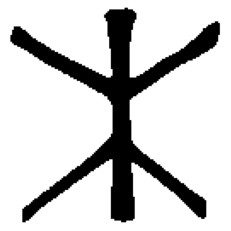

In [7]:
sample_image_path = "/content/data/clean_bold_magic_symbols/2.png"

def add_margins(image, image_size, random_rotation_degrees, color = (255, 255, 255)):
  
  # Get margin size.
  margin = image_size

  # Rotation
  rotation = random.randint(random_rotation_degrees[0], random_rotation_degrees[1])

  # Create a bigger image.
  tmp_img = Image.new("RGB", 
                      (image_size + margin, image_size + margin), 
                      color = color
  )

  # Paste the old image in the center
  cords = (
           round((tmp_img.size[0]-image.size[0])/2),
           round((tmp_img.size[1]-image.size[1])/2)
  )
  tmp_img.paste(image, cords)

  # Rotate the image.
  tmp_img = tmp_img.rotate(rotation)

  # Crop the image.
  crop_quarter_size = round(image_size / 2)
  crop_dims = (crop_quarter_size, 
               crop_quarter_size, 
               tmp_img.size[0] - crop_quarter_size, # Width - margin.
               tmp_img.size[1] - crop_quarter_size) # Height - margin
  tmp_img = tmp_img.crop(crop_dims)

  # Sharp
  factor = 50
  tmp_img = ImageEnhance.Sharpness(tmp_img).enhance(factor)
  
  if len(color) > 1:
    tmp_img = tmp_img.convert("1")

  return tmp_img

img = Image.open(sample_image_path)
img = add_margins(img, 128, random_rotation_degrees)

plt.imshow(img)
plt.axis("off")
plt.show()

def image_loader(path):
  image = Image.open(path)
  image = add_margins(image, IMAGE_SIZE, random_rotation_degrees)
  return image

def save_model(path, netG, netD, optimizerG, optimizerD, EPOCHS, criterion):
  try:
    os.mkdir(path)
  except:
    print("Folder exists")

  model_file_path = path + f"deep_arcane.model"

  # Save Model
  torch.save(
      {
        "generator": netG.state_dict(),
        "discriminator": netD.state_dict(),
        "generator_optimizer": optimizerG.state_dict(),
        "discriminator_optimizer": optimizerD.state_dict(),
        "epoch": EPOCHS,
        "loss": criterion,
      }, model_file_path
  )

## Settings

Found 2031 images in /content/data/


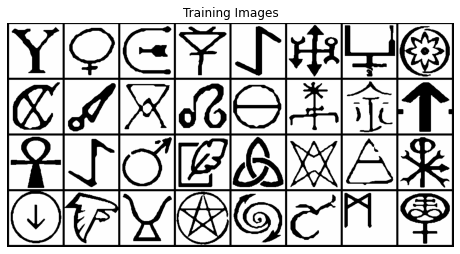

In [8]:

# Normalize the images.
if NC == 1:
    normalize = transforms.Normalize((0.5), (0.5))
else:
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# We can use an image folder dataset the way we have it setup.
# Create the dataset
transforms_to_apply = [
                       transforms.ToTensor(), 
                       normalize,
]

dataset = dset.ImageFolder(root=dataroot, 
                           loader=image_loader, 
                           transform=transforms.Compose(transforms_to_apply)
)

print(f"Found {len(dataset.imgs)} images in {dataroot}")

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

## Display Methods

In [9]:
def display_generated_images(tensor, limit):
    images = []
    limit if tensor.shape[0] > limit else tensor.shape[0]
    for i in range(0, min(limit, BATCH_SIZE)):
        image = tensor[i].detach().cpu().reshape(128, 128, 1)
        images.append(image)
        plt.axis("off")
        plt.imshow(image.reshape([128, 128]), cmap="gray")
        plt.show()
    return images

def create_display_grid(images):
    grid_size = round(len(images) / 4)
    f, axarr = plt.subplots(grid_size, grid_size)
    
    index = 0
    for row in range(0, grid_size):
        for col in range(0, grid_size):
            if index <= len(images):
                axarr[row,col].imshow(images[index], cmap="gray")
                axarr[row,col].axis('off')
                index += 1
    plt.tight_layout()
    plt.show()
    
def convert_tensor_to_image(image, width, height):
    # We multiply by 255, as the image is normalized 0-1.
    image = Image.fromarray(image.detach().cpu().numpy().reshape([width, height]) * 255)
    plt.imshow(image)
    color_img = Image.new("RGB", image.size)
    color_img.paste(image)
    return color_img
    
def convert_tensor_to_image(image, width, height):
    image = Image.fromarray(image.detach().cpu().numpy().reshape([width, height]) * 255)
    plt.imshow(image)
    color_img = Image.new("RGB", image.size)
    color_img.paste(image)
    return color_img


## Models

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, dropout):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.dropout = dropout
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(NZ, NGF * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 16),
            nn.Dropout2d(p=dropout),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NGF*16) x 4 x 4
            nn.ConvTranspose2d(NGF * 16, NGF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NGF*8) x 8 x 8
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NGF*4) x 16 x 16 
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.Dropout2d(p=dropout),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NGF*2) x 32 x 32
            nn.ConvTranspose2d(NGF * 2,     NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NGF) x 64 x 64
            nn.ConvTranspose2d(    NGF,      NC, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (NC) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)
    
    
# Create the generator
netG = Generator(ngpu, G_DROPOUT).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Load Model
# TODO:

# Print the model
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu, dropout):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.kernel_size = 2
        
        self.output_0 = 32
        self.output_1 = 64
        self.output_2 = 128
        self.output_3 = 256
        self.output_4 = 1

        self.input_1 = self.output_0
        self.input_2 = self.output_1
        self.input_3 = self.output_2
        self.input_4 = self.output_3
        
        self.stride_0 = 3
        self.stride_1 = 3
        self.stride_2 = 2
        self.stride_3 = 2
        self.stride_4 = 2
        
        self.padding_0 = 1
        self.padding_1 = 1
        self.padding_2 = 1
        self.padding_3 = 1
        self.padding_4 = 1
        
        self.main = nn.Sequential(

            # input is (NC) x 128 x 128
            nn.Conv2d(NC, NDF, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NDF) x 64 x 64
            nn.Conv2d(NDF, NDF * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NDF*2) x 32 x 32
            nn.Conv2d(NDF * 2, NDF * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NDF*4) x 16 x 16 
            nn.Conv2d(NDF * 4, NDF * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NDF*8) x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(NDF * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (NDF*16) x 4 x 4
            nn.Conv2d(NDF * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
# Create the Discriminator
netD = Discriminator(ngpu, D_DROPOUT).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(25, 4800, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.0, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(4800, 2400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(2400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): ConvTranspose2d(2400, 1200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): ConvTranspose2d(1200, 600, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout2d(p

In [11]:
# Log metrics with wandb
wandb.watch([netG, netD])

# Initialize BCELoss function
criterion = nn.BCELoss(reduction="mean")

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(IMAGE_SIZE, NZ, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


# Continue Training

In [12]:
model_path_to_load = f"{MODEL_DIR}{wandb.run.id}/deep_arcane.model"
model_path_to_load

'/content/gdrive/MyDrive/dl_models/deep_arcane_models/3ewmebh2/deep_arcane.model'

In [13]:
if wandb.run.resumed:
    checkpoint = torch.load(model_path_to_load)

    netG.load_state_dict(checkpoint["generator"])
    netD.load_state_dict(checkpoint["discriminator"])
    optimizerG.load_state_dict(checkpoint["generator_optimizer"])
    optimizerD.load_state_dict(checkpoint["discriminator_optimizer"])

    EPOCHS += checkpoint["epoch"]
    starting_epoch = checkpoint["epoch"]

    del checkpoint

## Train Model

In [ ]:
lowest_D_G_z2 = 99999

print("Starting Training Loop...")
# For each epoch
for epoch in range(starting_epoch, EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        
        # Smooth labels.
        real_label = random.uniform(real_range[0], real_range[1])
        fake_label = random.uniform(fake_range[0], fake_range[1])

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train th all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NZ, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wandb.log({"epoch": epoch, "D_x": D_x, "D_G_z1": D_G_z1, "D_G_z2": D_G_z2})
            

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
    if epoch > EPOCH_TO_START_SAVING and epoch % save_every == 0:
        lowest_D_G_z2 = D_G_z2
        print("Saving model.")
        save_model(model_path, netG, netD, optimizerG, optimizerD, epoch, criterion)

        noise = torch.randn(BATCH_SIZE, NZ, 1, 1, device=device)
        generated_images = netG(noise)
        images = display_generated_images(generated_images, samples)
        pil_images = [convert_tensor_to_image(image, IMAGE_SIZE, IMAGE_SIZE) for image in images]       
        wandb.log({"example": [wandb.Image(img) for img in pil_images]})


Starting Training Loop...
[67/6067][0/64]	Loss_D: 2.1947	Loss_G: 4.8145	D(x): 0.3880	D(G(z)): 0.0040 / 0.1534


# Save Model

In [ ]:
save_model(model_path, netG, netD, optimizerG, optimizerD, EPOCHS, criterion)